<a href="https://colab.research.google.com/github/enelene/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_NBEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
# Add the directory containing your script to the Python path
sys.path.append('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main')

In [3]:
!pip install -r  drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [4]:
import pandas as pd
import numpy as np
import os
import warnings
import wandb
import torch
import gc

# NeuralForecast imports
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MAE

In [5]:
def wmae(y_true, y_pred, is_holiday):
    """Computes the Weighted Mean Absolute Error."""
    weights = np.where(np.array(is_holiday, dtype=bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [6]:
wandb.login(key = "720b5644412076fa3e35eb1ffccab9895b8369db")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egabe21 (egabe21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
HORIZON = 39
# A common rule of thumb for N-BEATS is to use an input size that is a multiple of the horizon.
INPUT_SIZE =52

In [8]:
try:
    train_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/train_final.csv', parse_dates=['Date'])
    validation_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/validation_final.csv', parse_dates=['Date'])
    test_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/test_final.csv', parse_dates=['Date'])
    print("Successfully loaded all pre-split data files.")
except KeyError:
    print("ERROR: Make sure you have uploaded all three required CSV files.")
    raise

Successfully loaded all pre-split data files.


In [9]:
def prepare_for_nf(df, is_train=True):
    """Prepares a DataFrame for NeuralForecast by renaming and creating necessary columns."""
    df_copy = df.copy()
    # Create the 'unique_id' by combining Store and Dept
    df_copy['unique_id'] = df_copy['Store'].astype(str) + '_' + df_copy['Dept'].astype(str)
    # Rename 'Date' to 'ds'
    df_copy.rename(columns={'Date': 'ds'}, inplace=True)
    # If it's a dataset with a target, rename the target to 'y'
    if is_train and 'Weekly_Sales' in df_copy.columns:
        df_copy.rename(columns={'Weekly_Sales': 'y'}, inplace=True)
    return df_copy

In [10]:

# Prepare the training and validation sets
nf_train_df = prepare_for_nf(train_df)
nf_validation_df = prepare_for_nf(validation_df)

# For evaluation, we need the true 'y' values and holiday flags from the validation set
y_val_true = nf_validation_df['y']
is_holiday_val = nf_validation_df['IsHoliday']

In [11]:

# --- Define Exogenous Variables for N-BEATS ---
# N-BEATS in its standard implementation only uses future exogenous variables.
futr_exog_list = [
    'IsHoliday', 'Month', 'IsBlackFridayWeek', 'IsLaborDayWeek',
    'WeekOfYear', 'Day', 'IsChristmasWeek', 'IsSuperBowlWeek', 'Year'
]
# Ensure all selected features exist in the dataframe
futr_exog_list = [f for f in futr_exog_list if f in train_df.columns]
print(f"Using {len(futr_exog_list)} future exogenous features for N-BEATS.")


Using 9 future exogenous features for N-BEATS.


In [12]:

# Clear GPU memory before training
gc.collect()
torch.cuda.empty_cache()


In [13]:
models = [
    NBEATS(
        h=HORIZON,
        input_size=INPUT_SIZE,
        # Define the interpretable architecture
        stack_types=['trend', 'seasonality', 'identity'],
        n_blocks=[3, 4, 3], # Number of blocks for each stack type
        mlp_units=[[256, 256], [256, 256], [256, 256]], # MLP layer units for each stack
        n_harmonics=2, # Number of fourier terms for seasonality
        n_polynomials=2, # Degree of polynomial for trend
        # General training parameters
        max_steps=1000,
        early_stop_patience_steps=10,
        loss=MAE(),
        scaler_type='robust',
        random_seed=42
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [14]:
# The NeuralForecast object manages the training process
nf = NeuralForecast(models=models, freq='W-FRI')

# The fit method takes the training dataframe.
# It will use the last part of the training data for internal validation for early stopping.
nf.fit(df=nf_train_df, val_size=HORIZON)
print("Training complete.")

/usr/local/lib/python3.11/dist-packages/neuralforecast/core.py:553: UserWarning: Validation set size is larger than the shorter time-series.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.3 M     Trainable params
28.5 K    Non-trainable params
2.4 M     Total params
9.476     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Training complete.


In [15]:
predictions_df = nf.predict()

# Merge predictions with validation data to align for scoring
# We need to ensure the validation set has the same unique_ids as the predictions
validation_ids = predictions_df['unique_id'].unique()
nf_validation_df_filtered = nf_validation_df[nf_validation_df['unique_id'].isin(validation_ids)]

eval_df = pd.merge(nf_validation_df_filtered, predictions_df, on=['unique_id', 'ds'])


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:

# Calculate the WMAE score
wmae_score = wmae(eval_df['y'], eval_df['NBEATS'], eval_df['IsHoliday'])
print(f"Validation WMAE Score: {wmae_score:.4f}")

# Log the score to wandb
wandb.init(project="Walmart-Sales-Forecasting-NF", name="NBEATS-Interpretable-Run")
wandb.log({"validation_wmae": wmae_score})
wandb.finish()

Validation WMAE Score: 2437.1029


validation_wmae,▁
validation_wmae,2437.10289


In [18]:

# First, retrain the model on the combined train + validation data for maximum accuracy
full_train_df = pd.concat([train_df, validation_df])
nf_full_train_df = prepare_for_nf(full_train_df)

In [19]:

# For the final model, we can increase the steps and remove early stopping
final_models = [
    NBEATS(
        h=HORIZON,
        input_size=INPUT_SIZE,
        stack_types=['trend', 'seasonality', 'identity'],
        n_blocks=[3, 4, 3],
        mlp_units=[[256, 256], [256, 256], [256, 256]],
        n_harmonics=2,
        n_polynomials=2,
        max_steps=1500, # Train for a bit longer on the full data
        loss=MAE(),
        scaler_type='robust',
        random_seed=42
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [20]:

nf_final = NeuralForecast(models=final_models, freq='W-FRI')
nf_final.fit(df=nf_full_train_df) # No val_size needed here
print("Final model retrained on all available data.")

# Make final predictions
final_predictions_df = nf_final.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.3 M     Trainable params
28.5 K    Non-trainable params
2.4 M     Total params
9.476     Total estimated model params size (MB)
94        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


Final model retrained on all available data.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [21]:

# Format for submission
test_df['Id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].dt.strftime('%Y-%m-%d')
final_predictions_df.rename(columns={'ds': 'Date', 'NBEATS': 'Weekly_Sales'}, inplace=True)
final_predictions_df['Date'] = pd.to_datetime(final_predictions_df['Date'])
final_predictions_df['Store'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[0]))
final_predictions_df['Dept'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[1]))
prediction_map = final_predictions_df.set_index(['Store', 'Dept', 'Date'])['Weekly_Sales'].to_dict()
test_df['key'] = list(zip(test_df['Store'], test_df['Dept'], test_df['Date']))
test_df['Weekly_Sales'] = test_df['key'].map(prediction_map)

In [22]:

final_submission = test_df[['Id', 'Weekly_Sales']].copy()
final_submission['Weekly_Sales'] = final_submission['Weekly_Sales'].clip(lower=0).fillna(0)
final_submission.to_csv('nf_nbeats_submission.csv', index=False)

print("\nSubmission file 'nf_nbeats_submission.csv' created successfully.")
print(final_submission.head())


Submission file 'nf_nbeats_submission.csv' created successfully.
               Id  Weekly_Sales
0  1_1_2012-11-02  29057.943359
1  1_1_2012-11-09  23176.396484
2  1_1_2012-11-16  22435.439453
3  1_1_2012-11-23  22201.750000
4  1_1_2012-11-30  25912.041016


In [25]:
wandb.init()

In [26]:

# --- 10. Finalize Logging ---
# Log the submission file as a final artifact to our W&B run
print("Logging submission file as a W&B Artifact...")
artifact = wandb.Artifact('submission-file', type='submission')
artifact.add_file('nf_nbeats_submission.csv')
wandb.log_artifact(artifact)

wandb.finish()
print("\nExperiment complete. Check your W&B dashboard for all results and plots.")

Logging submission file as a W&B Artifact...



Experiment complete. Check your W&B dashboard for all results and plots.


In [27]:
import optuna

In [28]:

def objective(trial):
    """Optuna objective function to find the best N-BEATS hyperparameters."""
    # Define the search space for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    mlp_units = trial.suggest_categorical('mlp_units', [[[512, 512]], [[256, 256]], [[128, 128]]])
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)

    gc.collect()
    torch.cuda.empty_cache()

    models = [
        NBEATS(
            h=HORIZON,
            input_size=INPUT_SIZE,
            stack_types=['trend', 'seasonality', 'identity'],
            n_blocks=[n_blocks_trend, 4, 3], # Tune the number of trend blocks
            mlp_units=mlp_units * 3, # Use the same MLP structure for all stacks
            n_harmonics=2,
            n_polynomials=2,
            learning_rate=learning_rate,
            max_steps=800, # Use fewer steps for faster tuning
            early_stop_patience_steps=5,
            loss=MAE(),
            scaler_type='robust',
            random_seed=42
        )
    ]
    nf = NeuralForecast(models=models, freq='W-FRI')
    nf.fit(df=nf_train_df, val_size=HORIZON)

    # --- Evaluation ---
    predictions_df = nf.predict()
    validation_ids = predictions_df['unique_id'].unique()
    nf_validation_df_filtered = nf_validation_df[nf_validation_df['unique_id'].isin(validation_ids)]
    eval_df = pd.merge(nf_validation_df_filtered, predictions_df, on=['unique_id', 'ds'])

    score = wmae(eval_df['y'], eval_df['NBEATS'], eval_df['IsHoliday'])
    return score

In [29]:

# Create a study and run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) # Run 10 trials to find good parameters



[I 2025-07-28 20:08:33,433] A new study created in memory with name: no-name-d4df6318-dd90-4ce6-b4db-5f12e6e1ead5
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is of type list.
  warnings.warn(message)
INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:09:01,363] Trial 0 finished with value: 2432.0975467515714 and parameters: {'learning_rate': 0.003562724380323279, 'mlp_units': [[128, 128]], 'n_blocks_trend': 1}. Best is trial 0 with value: 2432.0975467515714.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:09:36,904] Trial 1 finished with value: 2422.6905947734667 and parameters: {'learning_rate': 0.0015921542248477725, 'mlp_units': [[128, 128]], 'n_blocks_trend': 3}. Best is trial 1 with value: 2422.6905947734667.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:10:05,733] Trial 2 finished with value: 3021.5336831414634 and parameters: {'learning_rate': 0.004070894830262457, 'mlp_units': [[256, 256]], 'n_blocks_trend': 2}. Best is trial 1 with value: 2422.6905947734667.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:10:38,195] Trial 3 finished with value: 2396.1675893544702 and parameters: {'learning_rate': 0.001294557758645499, 'mlp_units': [[256, 256]], 'n_blocks_trend': 3}. Best is trial 3 with value: 2396.1675893544702.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:11:09,467] Trial 4 finished with value: 2443.4909575927345 and parameters: {'learning_rate': 0.0002229670937903676, 'mlp_units': [[512, 512]], 'n_blocks_trend': 2}. Best is trial 3 with value: 2396.1675893544702.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:11:41,364] Trial 5 finished with value: 2585.170485225668 and parameters: {'learning_rate': 0.00021462942374139818, 'mlp_units': [[128, 128]], 'n_blocks_trend': 3}. Best is trial 3 with value: 2396.1675893544702.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:12:12,448] Trial 6 finished with value: 2349.529023428896 and parameters: {'learning_rate': 0.0010392448172430175, 'mlp_units': [[512, 512]], 'n_blocks_trend': 2}. Best is trial 6 with value: 2349.529023428896.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is o

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:12:43,440] Trial 7 finished with value: 2600.081545121855 and parameters: {'learning_rate': 0.004621095090156167, 'mlp_units': [[512, 512]], 'n_blocks_trend': 2}. Best is trial 6 with value: 2349.529023428896.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is of

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:13:11,018] Trial 8 finished with value: 2470.960972210923 and parameters: {'learning_rate': 0.0014766822481297832, 'mlp_units': [[256, 256]], 'n_blocks_trend': 1}. Best is trial 6 with value: 2349.529023428896.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[512, 512]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[256, 256]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[128, 128]] which is o

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=800` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-07-28 20:13:39,283] Trial 9 finished with value: 2532.476898395341 and parameters: {'learning_rate': 0.0008614454964684899, 'mlp_units': [[128, 128]], 'n_blocks_trend': 1}. Best is trial 6 with value: 2349.529023428896.


In [30]:

best_params_raw = study.best_params
best_wmae = study.best_value
print(f"\n--- Tuning Complete ---")
print(f"Best WMAE found: {best_wmae:.4f}")
print(f"Best hyperparameters: {best_params_raw}")


--- Tuning Complete ---
Best WMAE found: 2349.5290
Best hyperparameters: {'learning_rate': 0.0010392448172430175, 'mlp_units': [[512, 512]], 'n_blocks_trend': 2}


In [31]:

# --- 7. Final Model Training and Submission ---
print("\n--- Training Final Model with Best Parameters ---")
run = wandb.init(project="Walmart-Sales-Forecasting-NF", name="NBEATS-Tuned-Run")
wandb.config.update(best_params_raw)
wandb.config.update({"input_size": INPUT_SIZE, "horizon": HORIZON})


--- Training Final Model with Best Parameters ---


In [39]:
# Define the quantiles we want to predict for our uncertainty interval
quantiles = [0.05, 0.5, 0.95]

In [32]:

# Prepare the final model parameters from the Optuna study
final_model_params = {
    'h': HORIZON,
    'input_size': INPUT_SIZE,
    'stack_types': ['trend', 'seasonality', 'identity'],
    'n_blocks': [best_params_raw['n_blocks_trend'], 4, 3],
    'mlp_units': best_params_raw['mlp_units'] * 3,
    'n_harmonics': 2,
    'n_polynomials': 2,
    'learning_rate': best_params_raw['learning_rate'],
    'max_steps': 1500, # Train for longer on the full data
    'loss': MAE(),
    'scaler_type': 'robust',
    'random_seed': 42
}

In [41]:
from neuralforecast.losses.pytorch import MAE, MQLoss

In [42]:

final_model_params = {
    'h': HORIZON,
    'input_size': INPUT_SIZE,
    'stack_types': ['trend', 'seasonality', 'identity'],
    'n_blocks': [best_params_raw['n_blocks_trend'], 4, 3],
    'mlp_units': best_params_raw['mlp_units'] * 3,
    'n_harmonics': 2,
    'n_polynomials': 2,
    'learning_rate': best_params_raw['learning_rate'],
    'max_steps': 1500,
    'loss': MQLoss(quantiles=quantiles), # Use MQLoss to predict quantiles
    'scaler_type': 'robust',
    'random_seed': 42
}

In [43]:

# Retrain on full data
full_train_df = pd.concat([train_df, validation_df])
nf_full_train_df = prepare_for_nf(full_train_df)

final_models = [NBEATS(**final_model_params)]
nf_final = NeuralForecast(models=final_models, freq='W-FRI')
nf_final.fit(df=nf_full_train_df)
print("Final model retrained.")

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 3      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 8.3 M  | train
-------------------------------------------------------
8.2 M     Trainable params
28.2 K    Non-trainable params
8.3 M     Total params
33.041    Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


Final model retrained.


Generating final submission file and visualizations...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Could not generate plot: You must call wandb.init() before wandb.log()


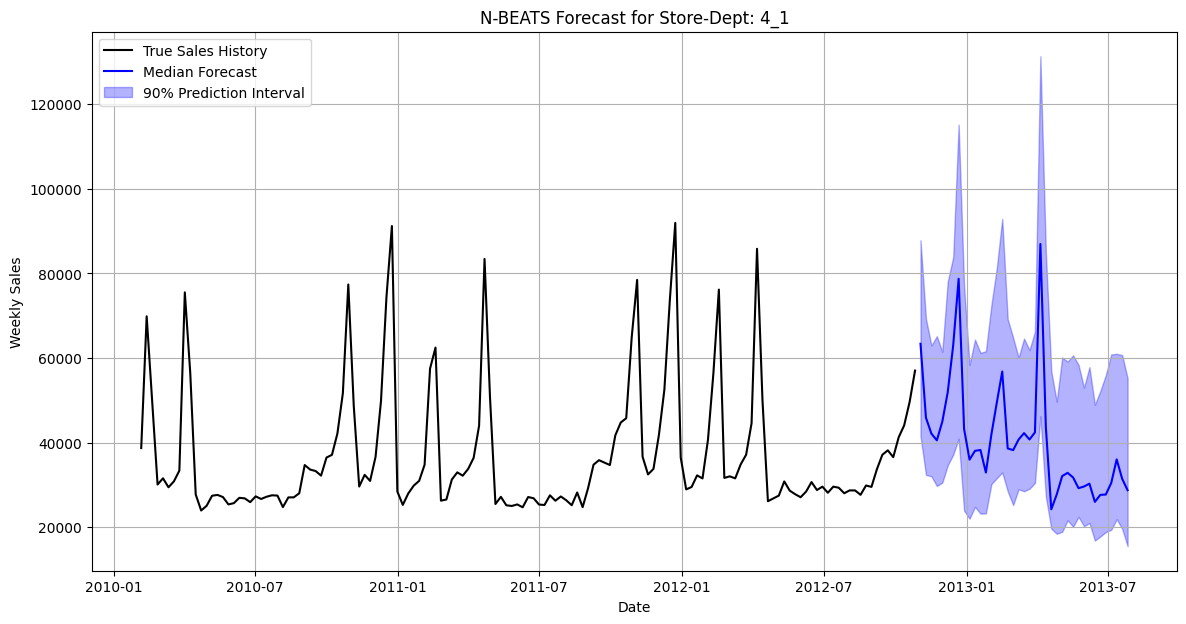

In [54]:

# --- 8. Generate Submission and Visualize ---
print("Generating final submission file and visualizations...")
final_predictions_df = nf_final.predict()

# --- Visualization of a Sample Forecast ---
try:
    sample_id = '4_1' # Choose a sample series to plot

    # Get historical data for the sample
    history_df = nf_full_train_df[nf_full_train_df['unique_id'] == sample_id]

    # Get forecast data for the sample
    forecast_df = final_predictions_df[final_predictions_df['unique_id'] == sample_id]

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot history
    ax.plot(history_df['ds'], history_df['y'], color='black', label='True Sales History')

    # Plot median forecast (q-50)
    ax.plot(forecast_df['ds'], forecast_df['NBEATS-median'], color='blue', label='Median Forecast')

    # Plot the uncertainty interval (between q-5 and q-95)
    ax.fill_between(
        forecast_df['ds'],
        forecast_df['NBEATS-lo-90.0'],
        forecast_df['NBEATS-hi-90.0'],
        alpha=0.3,
        color='blue',
        label='90% Prediction Interval'
    )

    ax.set_title(f'N-BEATS Forecast for Store-Dept: {sample_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')
    ax.legend()
    ax.grid(True)

    wandb.log({"Sample Forecast Plot": wandb.Image(fig)})
    plt.show()

except Exception as e:
    print(f"Could not generate plot: {e}")

In [48]:

# --- Generate Submission ---
print("Generating final submission file...")
final_predictions_df = nf_final.predict()

# Format for submission
test_df['Id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].dt.strftime('%Y-%m-%d')
final_predictions_df.rename(columns={'ds': 'Date', 'NBEATS': 'Weekly_Sales'}, inplace=True)
final_predictions_df['Date'] = pd.to_datetime(final_predictions_df['Date'])
final_predictions_df['Store'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[0]))
final_predictions_df['Dept'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[1]))
prediction_map = final_predictions_df.set_index(['Store', 'Dept', 'Date'])['Weekly_Sales'].to_dict()
test_df['key'] = list(zip(test_df['Store'], test_df['Dept'], test_df['Date']))
test_df['Weekly_Sales'] = test_df['key'].map(prediction_map)

final_submission = test_df[['Id', 'Weekly_Sales']].copy()
final_submission['Weekly_Sales'] = final_submission['Weekly_Sales'].clip(lower=0).fillna(0)
final_submission.to_csv('nf_nbeats_submission_tuned.csv', index=False)
print("\nSubmission file 'nf_nbeats_submission_tuned.csv' created successfully.")


Generating final submission file...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

KeyError: 'Weekly_Sales'

In [35]:

# Log final score and artifact
wandb.log({"final_validation_wmae": best_wmae})
artifact = wandb.Artifact('submission-file-nbeats-tuned', type='submission')
artifact.add_file('nf_nbeats_submission_tuned.csv')
wandb.log_artifact(artifact)
wandb.finish()

final_validation_wmae,▁
final_validation_wmae,2349.52902


Could not generate plot: 'ds'


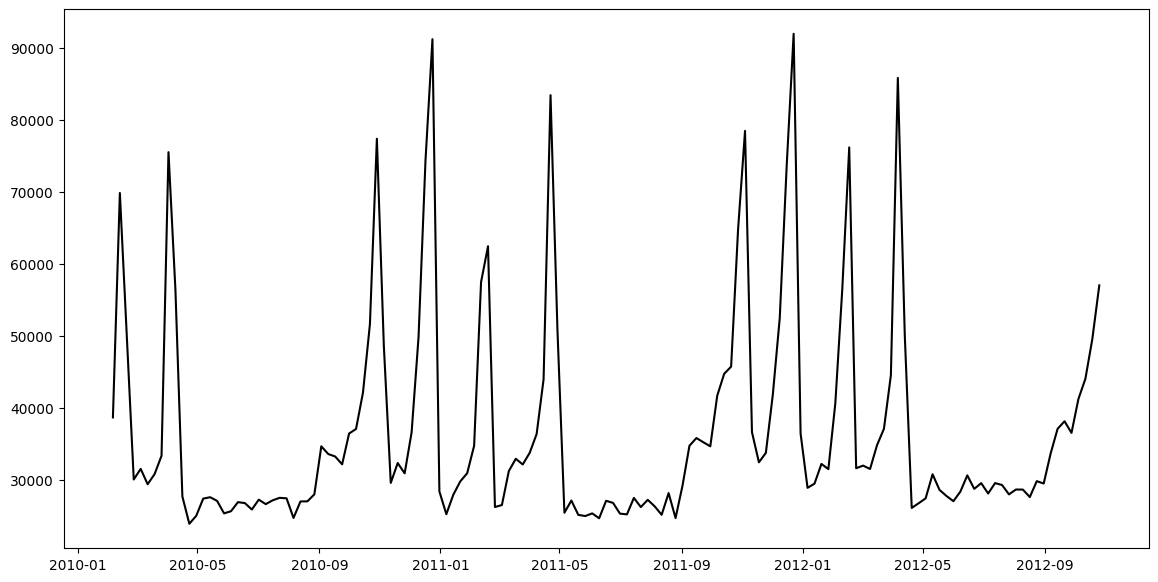

In [46]:

# --- Visualization of a Sample Forecast ---
try:
    sample_id = '4_1' # Choose a sample series to plot

    # Get historical data for the sample
    history_df = nf_full_train_df[nf_full_train_df['unique_id'] == sample_id]

    # Get forecast data for the sample
    forecast_df = final_predictions_df[final_predictions_df['unique_id'] == sample_id]

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot history
    ax.plot(history_df['ds'], history_df['y'], color='black', label='True Sales History')

    # --- FIX: Use the correct column names for quantile forecasts ---
    # The columns are named 'NBEATS-0.05', 'NBEATS-0.5', 'NBEATS-0.95'
    median_forecast_col = 'NBEATS-0.5'
    lower_quantile_col = 'NBEATS-0.05'
    upper_quantile_col = 'NBEATS-0.95'

    # Plot median forecast
    ax.plot(forecast_df['ds'], forecast_df[median_forecast_col], color='blue', label='Median Forecast')

    # Plot the uncertainty interval
    ax.fill_between(
        forecast_df['ds'],
        forecast_df[lower_quantile_col],
        forecast_df[upper_quantile_col],
        alpha=0.3,
        color='blue',
        label='90% Prediction Interval'
    )

    ax.set_title(f'N-BEATS Forecast for Store-Dept: {sample_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')
    ax.legend()
    ax.grid(True)

    wandb.log({"Sample Forecast Plot": wandb.Image(fig)})
    plt.show()

except Exception as e:
    print(f"Could not generate plot: {e}")

In [47]:
test_df['Id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].dt.strftime('%Y-%m-%d')
# --- FIX: Use the correct median forecast column name ---
final_predictions_df.rename(columns={'ds': 'Date', median_forecast_col: 'Weekly_Sales'}, inplace=True)
final_predictions_df['Date'] = pd.to_datetime(final_predictions_df['Date'])
final_predictions_df['Store'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[0]))
final_predictions_df['Dept'] = final_predictions_df['unique_id'].apply(lambda x: int(x.split('_')[1]))
prediction_map = final_predictions_df.set_index(['Store', 'Dept', 'Date'])['Weekly_Sales'].to_dict()
test_df['key'] = list(zip(test_df['Store'], test_df['Dept'], test_df['Date']))
test_df['Weekly_Sales'] = test_df['key'].map(prediction_map)


KeyError: 'Weekly_Sales'